# Procurement Fraud Detection

<b>Business Objective</b>: The objective of the project is to predict frauds in the procurement process as these type of frauds result in decrease in revenue and profits for the company.

Relevant features are chosen to train the model which will help to predict the fraud in procurement.

In [1]:
# Importing the necessary libraries

from datetime import datetime
import os
import random
from faker import Faker
f = Faker()
import pickle

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import scipy
import warnings
warnings.filterwarnings(action = 'ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
# Importing the dataset

dataset = pd.read_excel('D:/Project 83/Python files/Procurement_Data2.xlsx')

In [3]:
dataset.head()

,Po_num,Invoice_date,Requesting_auth,Approving_manager,Supplier,Product,Contract,Unit_price,PO_Quantity,City,Market_price,Total_cost
0,PO 00001,2016-01-01,Randall Smith,Jennifer Delgado,Rancherâ€™s Grocery,Pumpkin,1,56.36,119,Lucknow,56.86,6706.84
1,PO 00002,2016-01-01,Elijah Collins,Dennis Williams,Food Festive,Banana,1,44.59,143,Nagpur,38.21,6376.37
2,PO 00003,2016-01-01,Angela Hernandez,Mark Mclean,Food Festive,Capsicum,1,19.42,91,Lucknow,44.59,1767.22
3,PO 00004,2016-01-01,Jake Cunningham,Jasmine Long,Future FoodBetter Bites Deli,Apple,1,48.70,98,Ahmedabad,53.59,4772.60
4,PO 00005,2016-01-01,Patrick Wolf,Jeanette Estes,Freshmart Co-op,Cabbage,1,25.30,77,NashikDelhi,19.92,1948.10


In [4]:
# Dimensions of the dataset

dataset.shape

(21396, 12)

The dataset contains 21,396 rows and 12 features. 

In [5]:
# Name of features

dataset.columns

Index(['Po_num', 'Invoice_date', 'Requesting_auth', 'Approving_manager',
       'Supplier', 'Product', 'Contract', 'Unit_price', 'PO_Quantity', 'City',
       'Market_price', 'Total_cost'],
      dtype='object')

## Data Dictionary:

| Feature | Description | Data type | Relevance |
| --| -- | --| --|
| PO_number | Purchase Order Number | Nominal | Irrelevant|
| Invoice Date | Date of transaction | Datetime | Irrelevant|
| Requesting_auth | Employee responsible for PO | Nominal | Relevant|
| Approving_manager | Manager giving permission for the PO  | Nominal | Relevant|
| Supplier | Supplier Name | Nominal | Relevant|
| Product | Name of grocery | Nominal | Relevant|
| Contract | Whether there is Contract between Company and Supplier | Nominal | Relevant|
| Unit_price | Unit price of product procured | Ratio | Relevant|
| PO_Quantity | Total quantity of product procured | Ratio | Relevant|
| City | Region of transaction | Nominal | Relevant|
| Market_price | Actual Market price of the product | Ratio | Relevant|
| Total_cost | Total expenditure | Ratio | Relevant|

# Data Pre-Processing

In [6]:
# Function to calculate missing value percentage

def check_missing_per(data):
    missing_per = np.round((dataset[data].isnull().sum()/dataset.shape[0]), 4) * 100
    print(f'Missing value in {data}: {missing_per} %')

In [7]:
# Checking for null values

dataset.isnull().sum()

Po_num                0
Invoice_date          0
Requesting_auth       0
Approving_manager    33
Supplier              0
Product              68
Contract              0
Unit_price           64
PO_Quantity           0
City                  0
Market_price          0
Total_cost            0
dtype: int64

In [8]:
# Checking for missing values

for i in dataset.columns:
    check_missing_per(i)

Missing value in Po_num: 0.0 %
Missing value in Invoice_date: 0.0 %
Missing value in Requesting_auth: 0.0 %
Missing value in Approving_manager: 0.15 %
Missing value in Supplier: 0.0 %
Missing value in Product: 0.32 %
Missing value in Contract: 0.0 %
Missing value in Unit_price: 0.3 %
Missing value in PO_Quantity: 0.0 %
Missing value in City: 0.0 %
Missing value in Market_price: 0.0 %
Missing value in Total_cost: 0.0 %


There are null values in Approving manager, Product and Unit_price feature. These are less than 10% and can be replaced using imputation method.
    Approving manager has 0.15% missing values and Product has 0.32% missing values which can be replaced with mode.
    Unit_Price has 0.3% missing values which can be replaced either by mean or median depending upon presence of outliers.

In [9]:
# Checking for duplicate values

dataset.duplicated().sum()

25

There are 25 duplicate values

In [10]:
# Removing duplicate values

dataset.drop_duplicates(inplace = True, ignore_index = True)

In [11]:
print(f'Dataset shape after duplicated rows removed: {dataset.shape}')

Dataset shape after duplicated rows removed: (21371, 12)


In [12]:
# Checking Descriptive statistics of the data

dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Contract,21371.0,0.776332,0.416712,0.00,1.000,1.00,1.00,1.0
Unit_price,21307.0,39.123971,13.717868,9.51,28.900,36.74,46.98,110.0
PO_Quantity,21371.0,100.349305,29.002891,50.00,75.000,101.00,126.00,150.0
Market_price,21371.0,39.133498,13.738941,9.74,28.925,36.74,47.09,110.0
Total_cost,21371.0,3916.329439,1846.754579,0.00,2555.865,3567.12,4901.59,15290.0


In [13]:
# Checking datatypes of the features

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21371 entries, 0 to 21370
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Po_num             21371 non-null  object        
 1   Invoice_date       21371 non-null  datetime64[ns]
 2   Requesting_auth    21371 non-null  object        
 3   Approving_manager  21338 non-null  object        
 4   Supplier           21371 non-null  object        
 5   Product            21303 non-null  object        
 6   Contract           21371 non-null  int64         
 7   Unit_price         21307 non-null  float64       
 8   PO_Quantity        21371 non-null  int64         
 9   City               21371 non-null  object        
 10  Market_price       21371 non-null  float64       
 11  Total_cost         21371 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(6)
memory usage: 2.0+ MB


There are features with incorrect datatypes.                        
For example: Unit_price is object instead of float

In [14]:
# Defining Outliers 

def create_boxplot(data):
    sns.boxplot(data = dataset[data])
    plt.title(f'Outliers in {data}')
    plt.show()

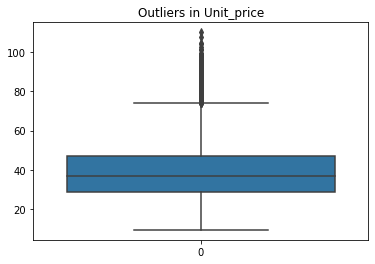

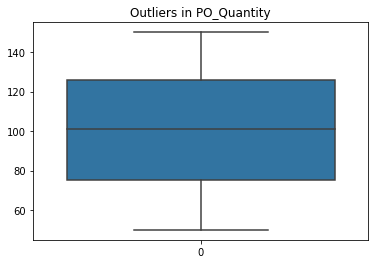

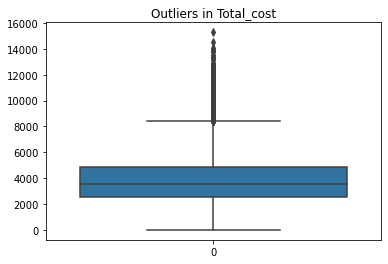

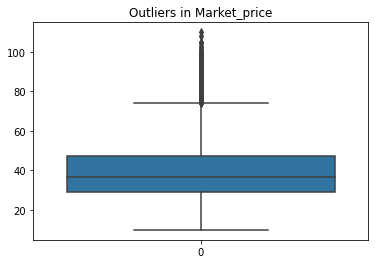

In [15]:
create_boxplot('Unit_price')
create_boxplot('PO_Quantity')
create_boxplot('Total_cost')
create_boxplot('Market_price')

PO_Quantity and Market Price have no outliers. There are outliers present in the Unit_price and Total_price features

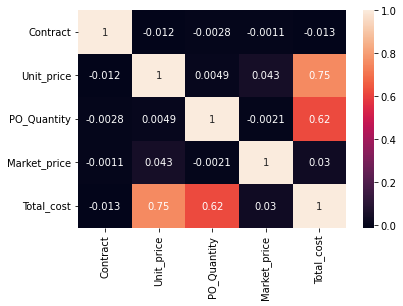

In [16]:
# Correlation Matrix

sns.heatmap(dataset.corr(), annot = True)
plt.show()

There is strong correlation between:

    Total_cost <------> Unit_price
    Total_cost <------> PO_Quantity

# Exploratory Data Analysis

## Univariate Analysis

In [17]:
# Defining function to create Countplot
def create_countplot(temp, color = 'blue'):
    plt.figure(figsize = (10, 6))

    value = dataset[temp].value_counts().values
    index = dataset[temp].value_counts().index

    plot1 = sns.barplot(x = value, y = index, color = color)
    plt.title(f'Total PO created by {temp} in the dataset')
    print(f'Total number of {temp}: {len(dataset[temp].unique())}')

    j = 0
    for i in dataset[temp].value_counts().values:
        plot1.annotate(i, (i+0.1,j+0.2))
        j += 1
    plt.show()
    print('\n ------------------------------------------------------------------------------------------------------------------------\n')

Total number of Requesting_auth: 27


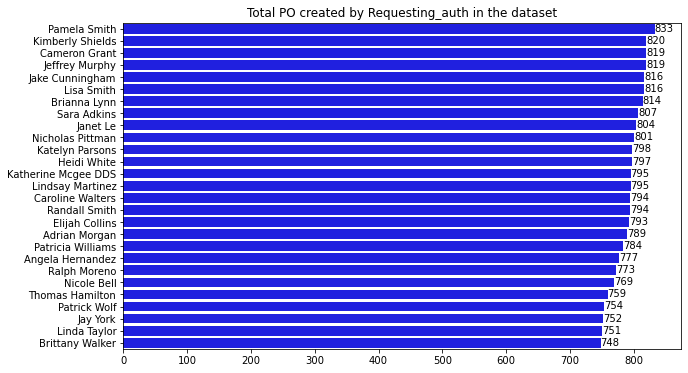


 ------------------------------------------------------------------------------------------------------------------------

Total number of Approving_manager: 17


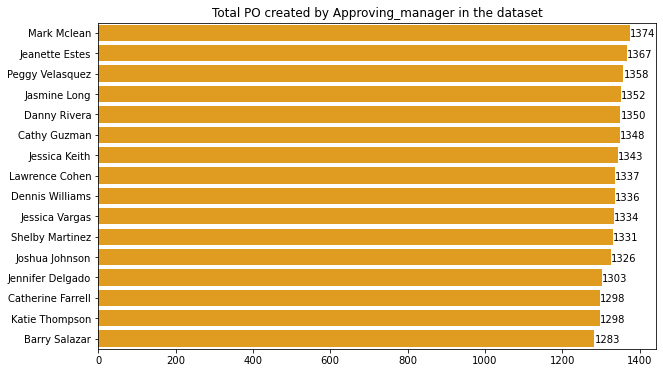


 ------------------------------------------------------------------------------------------------------------------------

Total number of Supplier: 17


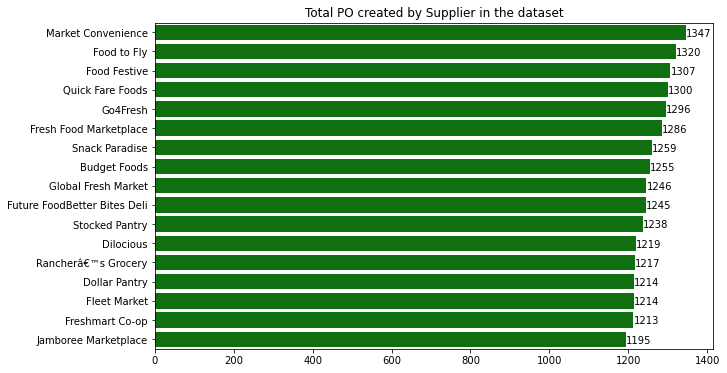


 ------------------------------------------------------------------------------------------------------------------------

Total number of City: 14


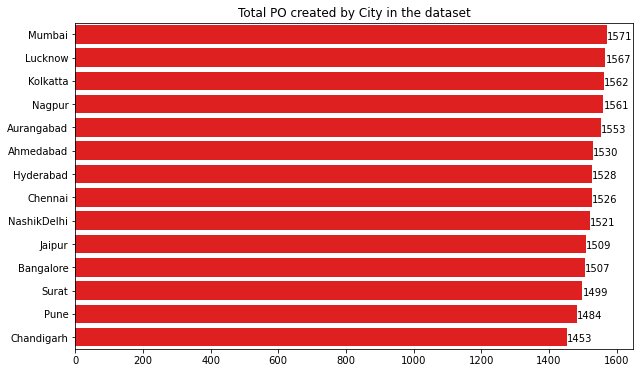


 ------------------------------------------------------------------------------------------------------------------------

Total number of Product: 14


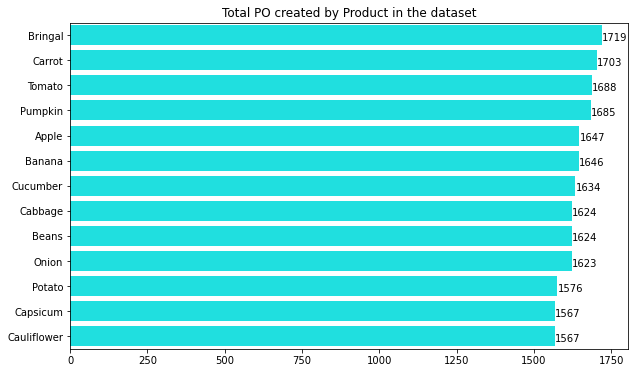


 ------------------------------------------------------------------------------------------------------------------------



In [18]:
# Generating Countplots

create_countplot('Requesting_auth')
create_countplot('Approving_manager', 'orange')
create_countplot('Supplier', 'green')
create_countplot('City', 'red')
create_countplot('Product', 'cyan')

Observations:
1. There are 27 unique requesting authorities in the dataset. Pamela Smith has made the highest requests which was 833 PO orders.
2. The dataset consists of 17 managers of which Mark Mclean has approved the 1374 PO orders.
3. There are 17 Suppliers from whom groceries are procured. Total 1347 orders are suuplied by Market Convenience and 1320 orders by Food to Fly
4. In city feature, we can see there are a total of 14 cities in the dataset. Mumbai followed by Lucknow city have the most procurement transactions.

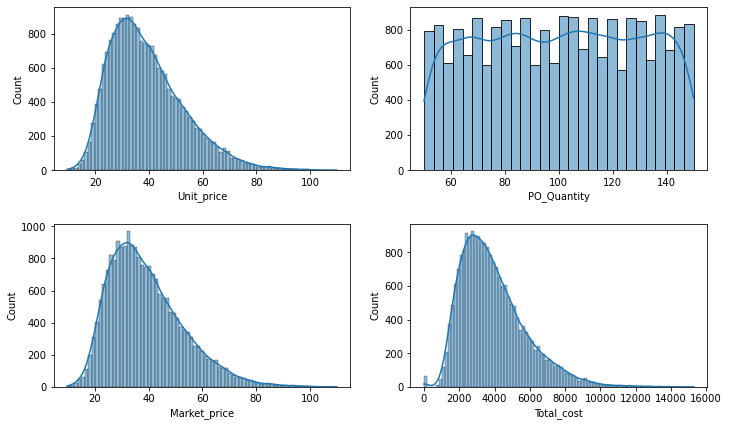

In [19]:
# Histogram

fig, ax = plt.subplots(2, 2, figsize = (10,6))
ax = ax.flatten()
index = 0
for data in ['Unit_price', 'PO_Quantity', 'Market_price', 'Total_cost']:
    sns.histplot(x = dataset[data], kde = 1, ax = ax[index])
    index += 1

plt.tight_layout(pad = 1, h_pad = 2, w_pad = 2)
plt.show()

In [20]:
# Checking for skewness

for i in dataset.columns:  
    if dataset[i].dtype != 'O' and dataset[i].dtype != '<M8[ns]':
        skew_value = scipy.stats.skew(dataset[i])
        print(f'Skewness for {i}: {skew_value}\n')

Skewness for Contract: -1.3262837224587796

Skewness for Unit_price: nan

Skewness for PO_Quantity: -0.012742747061843899

Skewness for Market_price: 0.8766837032730775

Skewness for Total_cost: 1.0679386243093756



    Distribution of PO Quantity is normal.
    There is positive skewness to Market price and Total cost feature.
    Skewness for unit price is NaN due to presence of missing values.

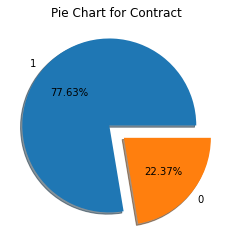

In [21]:
# Frequency of Contract in the dataset

plt.pie(dataset.Contract.value_counts(), explode = [0.1, 0.12], shadow = True, autopct = '%0.2f%%', labels = ['1', '0'])
plt.title('Pie Chart for Contract')
plt.show()

## BiVariate Analysis

In [22]:
# Defining function to create two way table between categorical features 

def create_two_way_table(data1, data2):
    # Creating crosstab to calculate frequency
    table = pd.crosstab(dataset[data1], dataset[data2], margins = False)
    plt.figure(figsize = (12, 10))
    sns.heatmap(table, annot = True, fmt = 'g')
    plt.title(f'Crosstab between {data1} and {data2}')
    plt.show()

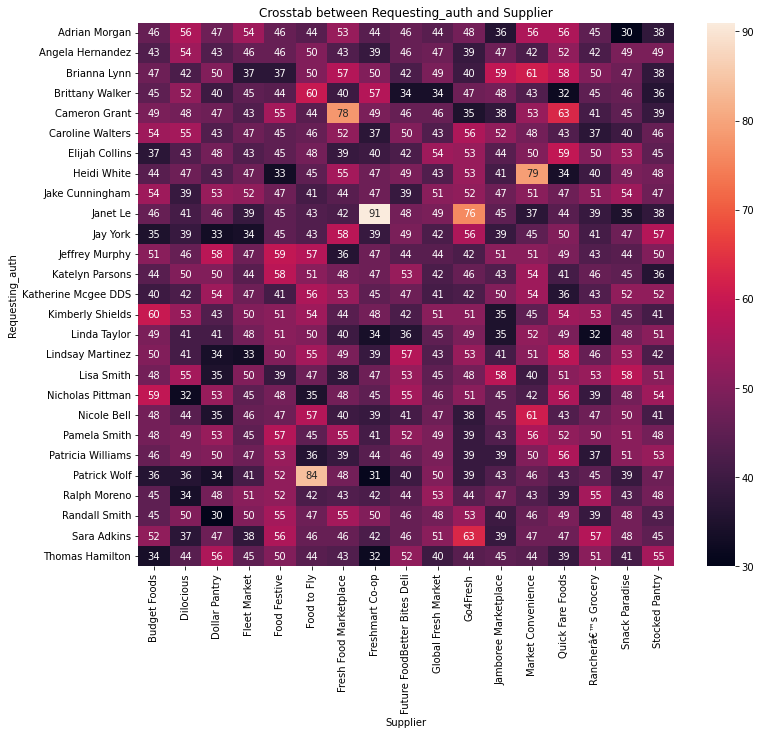

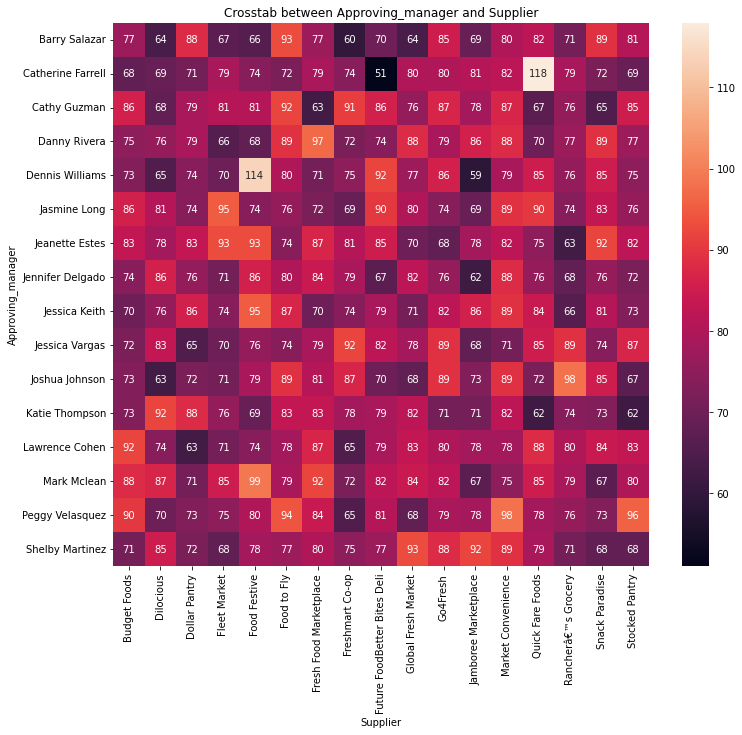

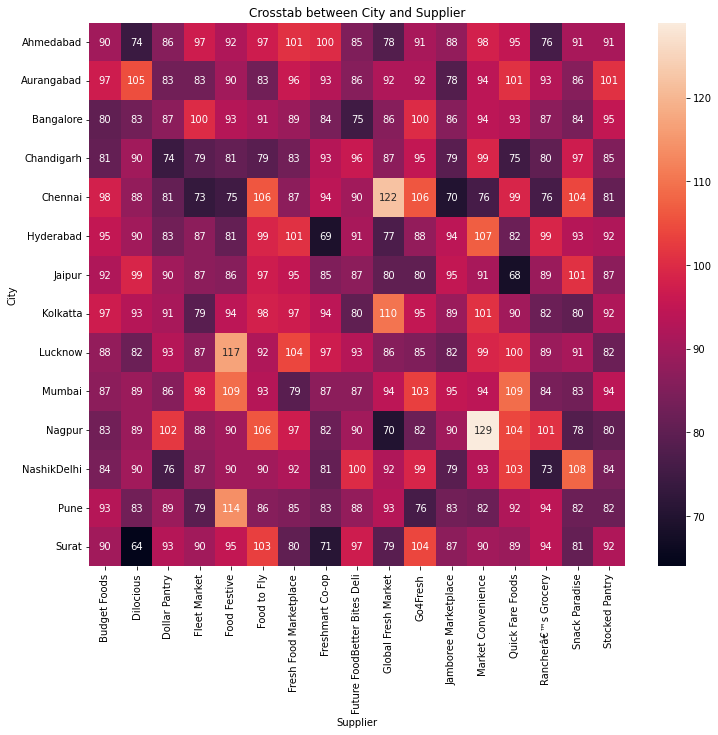

In [23]:
# Checking correlation between 

create_two_way_table('Requesting_auth', 'Supplier')
create_two_way_table('Approving_manager', 'Supplier')
create_two_way_table('City', 'Supplier')

The above heatmaps helps to visually detect some areas which needs to be focused on. For example, background checks and verifications to check for any conflict of interest or situations of bid-rigging activities.
In case of Conflict of Interest:   

    From requesting auth and Supplier crosstab, there seems strong relation between:
        Haidi White  <------> Market Convenience
        Cameron Grant <------> Fresh Food MarketPlace
        Janet Le <------> FreshMart Co-Op
        Patrick Wolf <------> Food to Fly
    
    From approving Manager and Supplier crosstab, there seems strong relation between:
        Dennis William  <------> Food Festive
        Catherine Farell <------> Quick Fare Food
        
In Case of Bid-Rigging:

    From City and Supplier crosstab,
        Market Convenience, strong foothold <-----> Nagpur
                            weak foothold  <------> Chennai
        Global Fresh Market, strong foothold <-----> Chennai
                            weak foothold  <------> Nagpur

For the above cases, proper background inspection and verification is necessary.

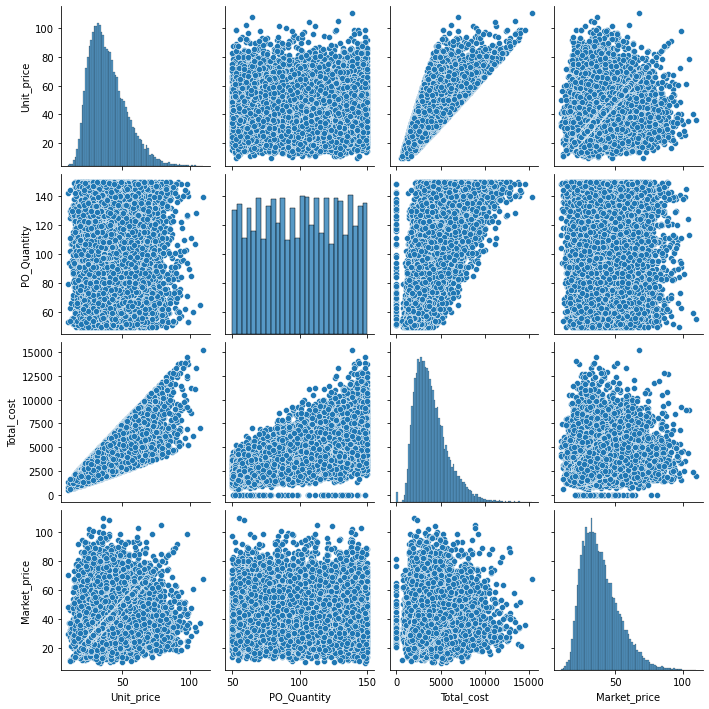

In [24]:
# Pair plot between numerical features 

list1 = dataset.loc[:, ['Unit_price', 'PO_Quantity', 'Total_cost', 'Market_price']]
sns.pairplot(list1)
plt.show()

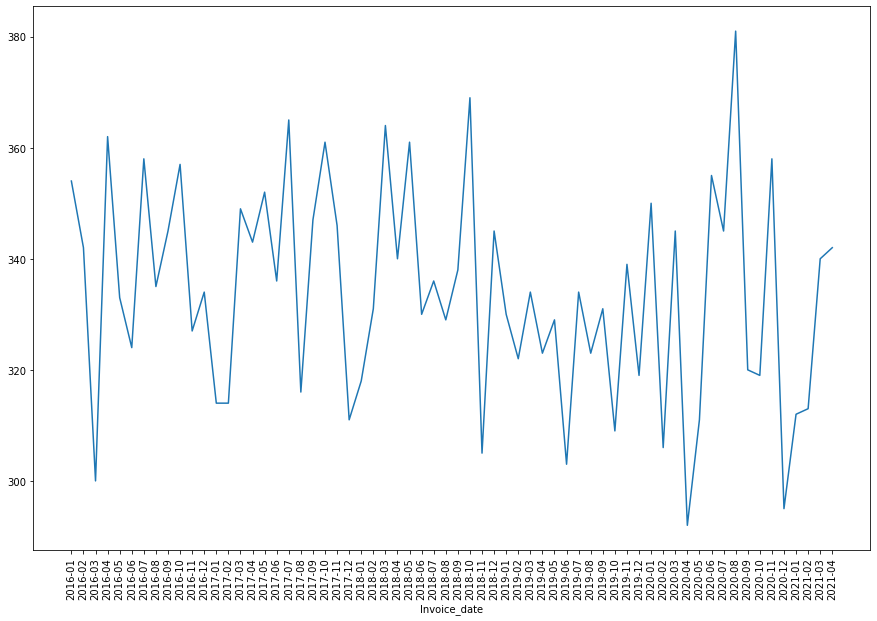

In [25]:
# Frequency of orders per month

date_dataset = dataset.Invoice_date.groupby(dataset.Invoice_date.dt.to_period('M')).count()
plt.figure(figsize = (15,10))
sns.lineplot(x = date_dataset.index.strftime('%Y-%m'), y = date_dataset.values)
plt.xticks(rotation = 90)
plt.show()

    Highest number of orders were in August 2020 and lowest number of orders were in April 2020.

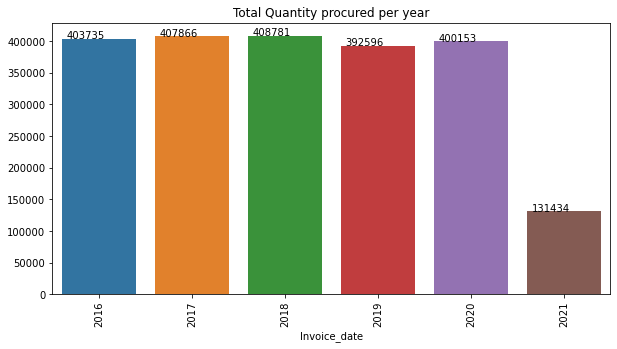

In [26]:
# Quantity sold per year

plt.figure(figsize = (10,5))
temp_data = dataset.PO_Quantity.groupby(dataset.Invoice_date.dt.to_period('Y')).sum()
b1 = sns.barplot(x = temp_data.index.strftime('%Y'), y = temp_data.values)
plt.xticks(rotation = 90)
plt.title('Total Quantity procured per year')
j = 0
for i in temp_data.values:
    b1.annotate(i, (j-0.35, i))
    j += 1
plt.show()

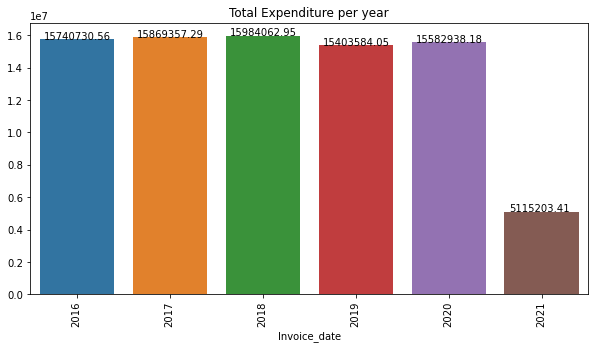

In [27]:
# Total Revenue per year

plt.figure(figsize = (10,5))
temp_data = dataset.Total_cost.groupby(dataset.Invoice_date.dt.to_period('Y')).sum()
b2 = sns.barplot(x = temp_data.index.strftime('%Y'), y = temp_data.values)
plt.xticks(rotation = 90)
plt.title('Total Expenditure per year')
j = 0
for i in temp_data.values:
    b2.annotate(i, (j - 0.35, i))
    j += 1
plt.show()

## Multivariate Analysis

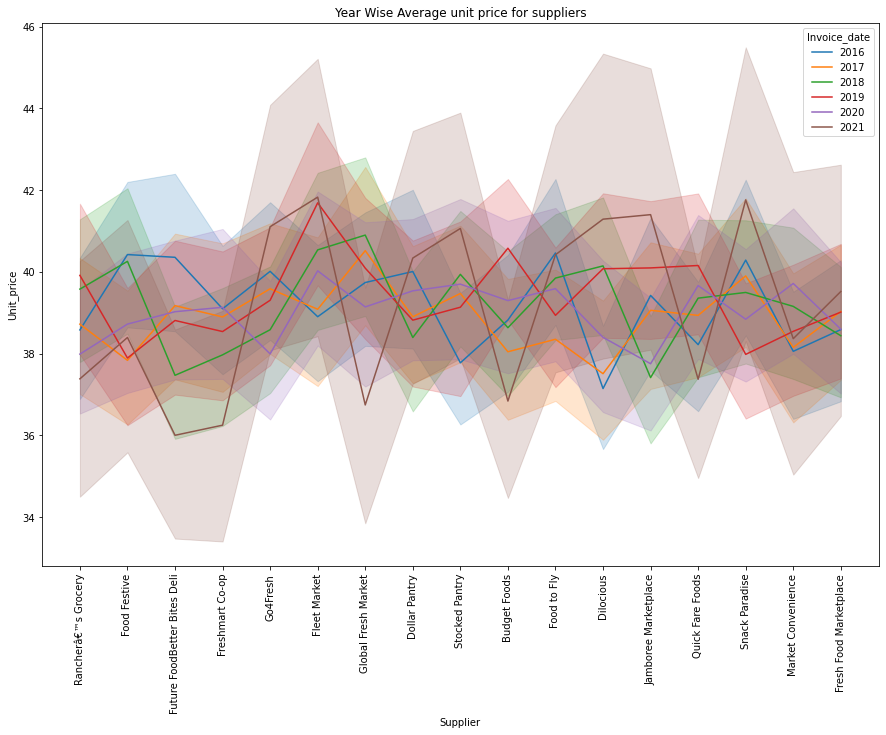

In [28]:
#  Lineplot for average unit price each year different suppliers 

plt.figure(figsize = (15,10))
sns.lineplot(x = dataset.Supplier, y = dataset.Unit_price, hue = dataset.Invoice_date.dt.to_period('Y'))
plt.title('Year Wise Average unit price for suppliers')
plt.xticks(rotation = 90)
plt.show()

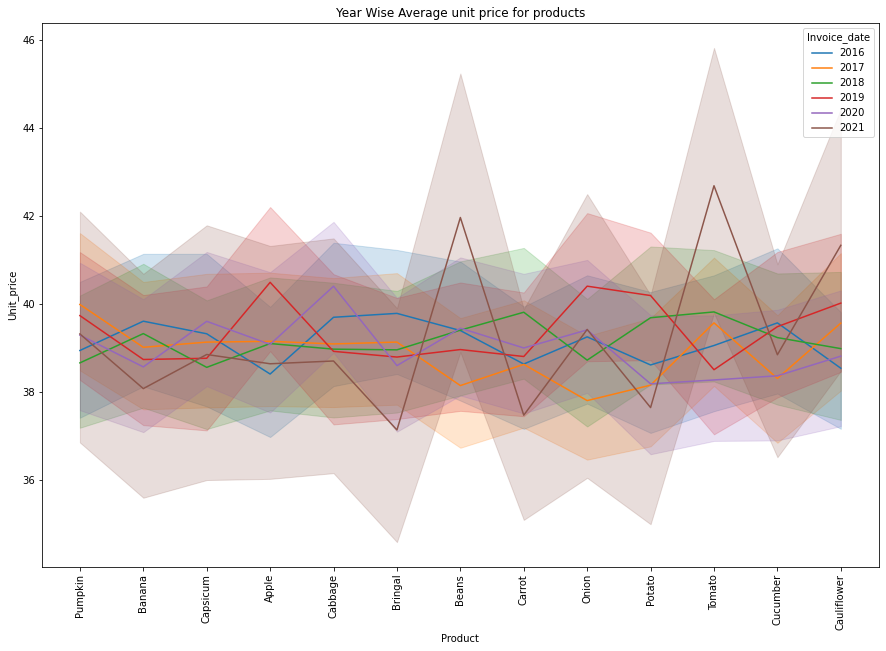

In [29]:
#  Lineplot for average unit price each year different products 

plt.figure(figsize = (15,10))
sns.lineplot(x = dataset.Product, y = dataset.Unit_price, hue = dataset.Invoice_date.dt.to_period('Y'))
plt.title('Year Wise Average unit price for products')
plt.xticks(rotation = 90)
plt.show()

## Feature Engineering

In [30]:
# Imputation

# # Imputing categorical features using mode
# dataset.Approving_manager.fillna(scipy.stats.mode(dataset.Approving_manager)[0][0], inplace = True)
# dataset.Product.fillna(scipy.stats.mode(dataset.Product)[0][0], inplace = True)

# # Imputing Unit Price feature using median
# dataset.Unit_price.fillna(np.median(dataset.Unit_price), inplace = True)

In [31]:
# The percentage of missing values in the dataset is very low compared to the dataset. Hence, we can drop the rows with null values

dataset.dropna(inplace = True)

In [32]:
print(f'Dataset shape after dropping NaN: {dataset.shape}')

Dataset shape after dropping NaN: (21206, 12)


In [33]:
# Winsorization

def winsorize(col):
    #Using IQR for outlier treatments
    
    IQR = dataset[col].quantile(0.75) - dataset[col].quantile(0.25)
    upper_end = dataset[col].quantile(0.75) + (1.5 * IQR)
    
    dataset[col] = np.where(dataset[col] > upper_end, upper_end, dataset[col])

In [34]:
# # Treating outliers using winsorize function

winsorize('Unit_price')
winsorize('Total_cost')
winsorize('Market_price')

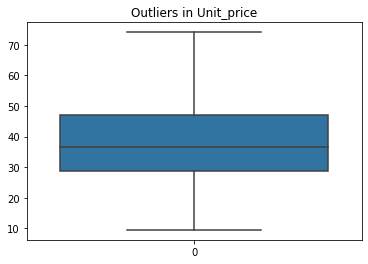

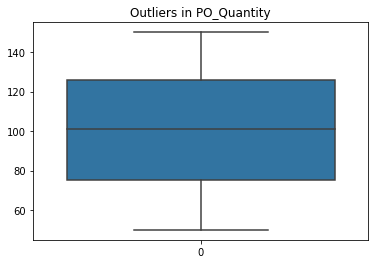

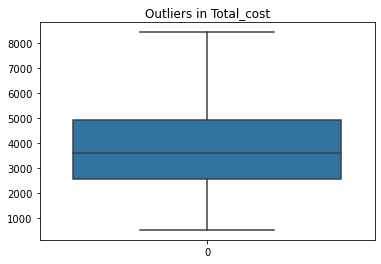

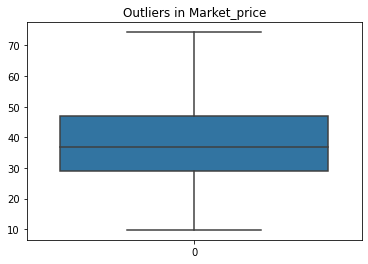

In [35]:
create_boxplot('Unit_price')
create_boxplot('PO_Quantity')
create_boxplot('Total_cost')
create_boxplot('Market_price')

All oultiers have been treated

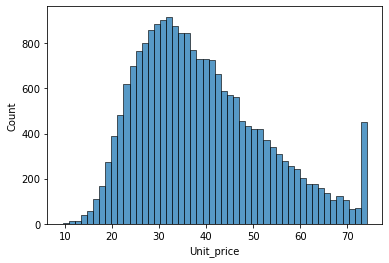

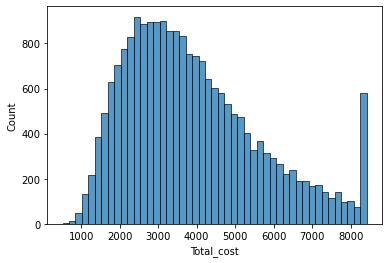

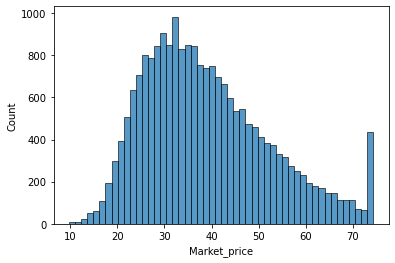

In [36]:
# Distribution after outlier treatment

sns.histplot(dataset.Unit_price)
plt.show()
sns.histplot(dataset.Total_cost)
plt.show()
sns.histplot(dataset.Market_price)
plt.show()

In [37]:
dataset.head(2)

,Po_num,Invoice_date,Requesting_auth,Approving_manager,Supplier,Product,Contract,Unit_price,PO_Quantity,City,Market_price,Total_cost
0,PO 00001,2016-01-01,Randall Smith,Jennifer Delgado,Rancherâ€™s Grocery,Pumpkin,1,56.36,119,Lucknow,56.86,6706.84
1,PO 00002,2016-01-01,Elijah Collins,Dennis Williams,Food Festive,Banana,1,44.59,143,Nagpur,38.21,6376.37


In [38]:
# Creating dummy variables

a1 = pd.get_dummies(dataset.Requesting_auth)
a2 = pd.get_dummies(dataset.Approving_manager)
a3 = pd.get_dummies(dataset.Supplier)
a4 = pd.get_dummies(dataset.Product)
a5 = pd.get_dummies(dataset.City)
a6 = pd.concat([a1,a2,a3,a4,a5], axis = 1)

# --------------------------------------------------------------------------------

## Creating JSON files

In [39]:
def conv(x):
    return x.item()

In [40]:
a1 = dataset.Requesting_auth
a2 = pd.get_dummies(dataset.Requesting_auth).astype(int)
a3 = pd.concat([a1, a2], axis = 1)
a3 = a3.set_index('Requesting_auth')
a4 = a3.drop_duplicates().sort_values(by='Requesting_auth')

Requesting_auth_dict = {}
j = 0
for i in a4.keys():
    Requesting_auth_dict[i] = (a4.values[j]).tolist()
    j += 1

In [41]:
a1 = dataset.Approving_manager
a2 = pd.get_dummies(dataset.Approving_manager).astype(int)
a3 = pd.concat([a1, a2], axis = 1)
a3 = a3.set_index('Approving_manager')
a4 = a3.drop_duplicates().sort_values(by='Approving_manager')

Approving_manager_dict = {}
j = 0
for i in a4.keys():
    Approving_manager_dict[i] = (a4.values[j]).tolist()
    j += 1

In [42]:
a1 = dataset.Supplier
a2 = pd.get_dummies(dataset.Supplier).astype(int)
a3 = pd.concat([a1, a2], axis = 1)
a3 = a3.set_index('Supplier')
a4 = a3.drop_duplicates().sort_values(by='Supplier')

Supplier_dict = {}
j = 0
for i in a4.keys():
    Supplier_dict[i] = (a4.values[j]).tolist()
    j += 1

In [43]:
a1 = dataset.Product
a2 = pd.get_dummies(dataset.Product).astype(int)
a3 = pd.concat([a1, a2], axis = 1)
a3 = a3.set_index('Product')
a4 = a3.drop_duplicates().sort_values(by='Product')

Product_dict = {}
j = 0
for i in a4.keys():
    Product_dict[i] = (a4.values[j]).tolist()
    j += 1

In [44]:
a1 = dataset.City
a2 = pd.get_dummies(dataset.City).astype(int)
a3 = pd.concat([a1, a2], axis = 1)
a3 = a3.set_index('City')
a4 = a3.drop_duplicates().sort_values(by='City')

City_dict = {}
j = 0
for i in a4.keys():
    City_dict[i] = (a4.values[j]).tolist()
    j += 1

In [45]:
dummy_dict = {}

dummy_dict['Requesting_Auth_names'] = Requesting_auth_dict
dummy_dict['Approving_manager_names'] = Approving_manager_dict
dummy_dict['Product_names'] = Product_dict
dummy_dict['Supplier_names'] = Supplier_dict
dummy_dict['City_names'] = City_dict

In [46]:
import json
with open('dummy_dict.json', 'w') as f:
    json.dump(dummy_dict, f)

# -----------------------------------------------------------------------------------------------------------

In [47]:
# Dropping irrelevant features

dataset.drop(columns = ['Po_num', 'Invoice_date', 'Requesting_auth', 'Approving_manager', 'Supplier', 'Product', 'City'], inplace = True)

In [48]:
# Converting categorical features into numerical using get_dummies

new_dataset = pd.concat([dataset, a6], axis = 1)

In [49]:
display(new_dataset.head(2))
print(f'Shape of new dataset: {new_dataset.shape}')

,Contract,Unit_price,PO_Quantity,Market_price,Total_cost,Adrian Morgan,Angela Hernandez,Brianna Lynn,Brittany Walker,Cameron Grant,Caroline Walters,Elijah Collins,Heidi White,Jake Cunningham,Janet Le,Jay York,Jeffrey Murphy,Katelyn Parsons,Katherine Mcgee DDS,Kimberly Shields,Linda Taylor,Lindsay Martinez,Lisa Smith,Nicholas Pittman,Nicole Bell,Pamela Smith,Patricia Williams,Patrick Wolf,Ralph Moreno,Randall Smith,Sara Adkins,Thomas Hamilton,Barry Salazar,Catherine Farrell,Cathy Guzman,Danny Rivera,Dennis Williams,Jasmine Long,Jeanette Estes,Jennifer Delgado,Jessica Keith,Jessica Vargas,Joshua Johnson,Katie Thompson,Lawrence Cohen,Mark Mclean,Peggy Velasquez,Shelby Martinez,Budget Foods,Dilocious,Dollar Pantry,Fleet Market,Food Festive,Food to Fly,Fresh Food Marketplace,Freshmart Co-op,Future FoodBetter Bites Deli,Global Fresh Market,Go4Fresh,Jamboree Marketplace,Market Convenience,Quick Fare Foods,Rancherâ€™s Grocery,Snack Paradise,Stocked Pantry,Apple,Banana,Beans,Bringal,Cabbage,Capsicum,Carrot,Cauliflower,Cucumber,Onion,Potato,Pumpkin,Tomato,Ahmedabad,Aurangabad,Bangalore,Chandigarh,Chennai,Hyderabad,Jaipur,Kolkatta,Lucknow,Mumbai,Nagpur,NashikDelhi,Pune,Surat
0,1,56.36,119,56.86,6706.84,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,44.59,143,38.21,6376.37,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


Shape of new dataset: (21206, 92)


## Standardization

In [50]:
# Standardzing the dataset

sc = StandardScaler()

sc_dataset = sc.fit_transform(new_dataset) # Fitting the data to standard scaler

sc_dataset = pd.DataFrame(sc_dataset, columns = new_dataset.columns) # Converting array to DataFrame

## KMeans Clustering

In [51]:
# Using Kmeans to form clusters

kmean = KMeans(n_clusters = 2, random_state = 45)  # Initializing the model 

kmean.fit(sc_dataset) # Fitting the model to the dataset

# The lowest SSE value
print(f'Kmeans Inertia: {kmean.inertia_}')

# The number of iterations required to converge
print(f'Iterations: {kmean.n_iter_}')

# Checking silhouette metric
print(f'Silhouette Score: {silhouette_score(sc_dataset, kmean.labels_)}')

Kmeans Inertia: 1922838.6170383045
Iterations: 13
Silhouette Score: 0.015468894141104085


In [52]:
# Predicting the clusters 

dataset['Labels'] = kmean.labels_
sc_dataset['Labels'] = kmean.labels_

In [53]:
sc_dataset.head()

,Contract,Unit_price,PO_Quantity,Market_price,Total_cost,Adrian Morgan,Angela Hernandez,Brianna Lynn,Brittany Walker,Cameron Grant,Caroline Walters,Elijah Collins,Heidi White,Jake Cunningham,Janet Le,Jay York,Jeffrey Murphy,Katelyn Parsons,Katherine Mcgee DDS,Kimberly Shields,Linda Taylor,Lindsay Martinez,Lisa Smith,Nicholas Pittman,Nicole Bell,Pamela Smith,Patricia Williams,Patrick Wolf,Ralph Moreno,Randall Smith,Sara Adkins,Thomas Hamilton,Barry Salazar,Catherine Farrell,Cathy Guzman,Danny Rivera,Dennis Williams,Jasmine Long,Jeanette Estes,Jennifer Delgado,Jessica Keith,Jessica Vargas,Joshua Johnson,Katie Thompson,Lawrence Cohen,Mark Mclean,Peggy Velasquez,Shelby Martinez,Budget Foods,Dilocious,Dollar Pantry,Fleet Market,Food Festive,Food to Fly,Fresh Food Marketplace,Freshmart Co-op,Future FoodBetter Bites Deli,Global Fresh Market,Go4Fresh,Jamboree Marketplace,Market Convenience,Quick Fare Foods,Rancherâ€™s Grocery,Snack Paradise,Stocked Pantry,Apple,Banana,Beans,Bringal,Cabbage,Capsicum,Carrot,Cauliflower,Cucumber,Onion,Potato,Pumpkin,Tomato,Ahmedabad,Aurangabad,Bangalore,Chandigarh,Chennai,Hyderabad,Jaipur,Kolkatta,Lucknow,Mumbai,Nagpur,NashikDelhi,Pune,Surat,Labels
0,0.537187,1.308094,0.641843,1.342738,1.611307,-0.196323,-0.194371,-0.199283,-0.190151,-0.199539,-0.196323,-0.195804,-0.196581,-0.199539,-0.197743,-0.190816,-0.199794,-0.196969,-0.196063,-0.199794,-0.191081,-0.196323,-0.199027,-0.197356,-0.193192,-0.201954,-0.194763,-0.191743,-0.193717,5.090301,-0.198,-0.191875,-0.252713,-0.254714,-0.259819,-0.260025,-0.258368,-0.259715,-0.261984,3.924362,-0.259197,-0.257952,-0.257328,-0.254398,-0.25899,-0.262086,-0.260851,-0.258056,-0.250169,-0.246531,-0.246208,-0.245884,-0.255762,-0.256389,-0.253767,-0.245561,-0.249210,-0.248676,-0.253135,-0.243068,-0.259197,-0.253978,4.077695,-0.250063,-0.246638,-0.283638,-0.289897,-0.287789,-0.29663,-0.287885,-0.282082,-0.295311,-0.282277,-0.288749,-0.287693,-0.282861,3.405895,-0.293987,-0.277969,-0.280618,-0.2756,-0.270515,-0.277772,-0.277772,-0.275996,-0.281497,3.549973,-0.282472,-0.281107,-0.277181,-0.273614,-0.268804,0
1,0.537187,0.421981,1.469197,-0.059667,1.421613,-0.196323,-0.194371,-0.199283,-0.190151,-0.199539,-0.196323,5.107153,-0.196581,-0.199539,-0.197743,-0.190816,-0.199794,-0.196969,-0.196063,-0.199794,-0.191081,-0.196323,-0.199027,-0.197356,-0.193192,-0.201954,-0.194763,-0.191743,-0.193717,-0.196452,-0.198,-0.191875,-0.252713,-0.254714,-0.259819,-0.260025,3.870453,-0.259715,-0.261984,-0.254818,-0.259197,-0.257952,-0.257328,-0.254398,-0.25899,-0.262086,-0.260851,-0.258056,-0.250169,-0.246531,-0.246208,-0.245884,3.909891,-0.256389,-0.253767,-0.245561,-0.249210,-0.248676,-0.253135,-0.243068,-0.259197,-0.253978,-0.245237,-0.250063,-0.246638,-0.283638,3.449497,-0.287789,-0.29663,-0.287885,-0.282082,-0.295311,-0.282277,-0.288749,-0.287693,-0.282861,-0.293609,-0.293987,-0.277969,-0.280618,-0.2756,-0.270515,-0.277772,-0.277772,-0.275996,-0.281497,-0.281692,-0.282472,3.557367,-0.277181,-0.273614,-0.268804,0
2,0.537187,-1.472961,-0.323404,0.420083,-1.224095,-0.196323,5.144795,-0.199283,-0.190151,-0.199539,-0.196323,-0.195804,-0.196581,-0.199539,-0.197743,-0.190816,-0.199794,-0.196969,-0.196063,-0.199794,-0.191081,-0.196323,-0.199027,-0.197356,-0.193192,-0.201954,-0.194763,-0.191743,-0.193717,-0.196452,-0.198,-0.191875,-0.252713,-0.254714,-0.259819,-0.260025,-0.258368,-0.259715,-0.261984,-0.254818,-0.259197,-0.257952,-0.257328,-0.254398,-0.25899,3.815538,-0.260851,-0.258056,-0.250169,-0.246531,-0.246208,-0.245884,3.909891,-0.256389,-0.253767,-0.245561,-0.249210,-0.248676,-0.253135,-0.243068,-0.259197,-0.253978,-0.245237,-0.250063,-0.246638,-0.283638,-0.289897,-0.287789,-0.29663,-0.287885,3.545067,-0.295311,-0.282277,-0.288749,-0.287693,-0.282861,-0.293609,-0.293987,-0.277969,-0.280618,-0.2756,-0.270515,-0.277772,-0.277772,-0.275996,-0.281497,3.549973,-0.282472,-0.281107,-0.277181,-0.273614,-0.268804,1
3,0.537187,0.731405,-0.082093,1.096847,0.501030,-0.196323,-0.194371,-0.199283,-0.1901

In [54]:
# Cluster labels proportion

sc_dataset.Labels.value_counts()

1    13260
0     7946
Name: Labels, dtype: int64

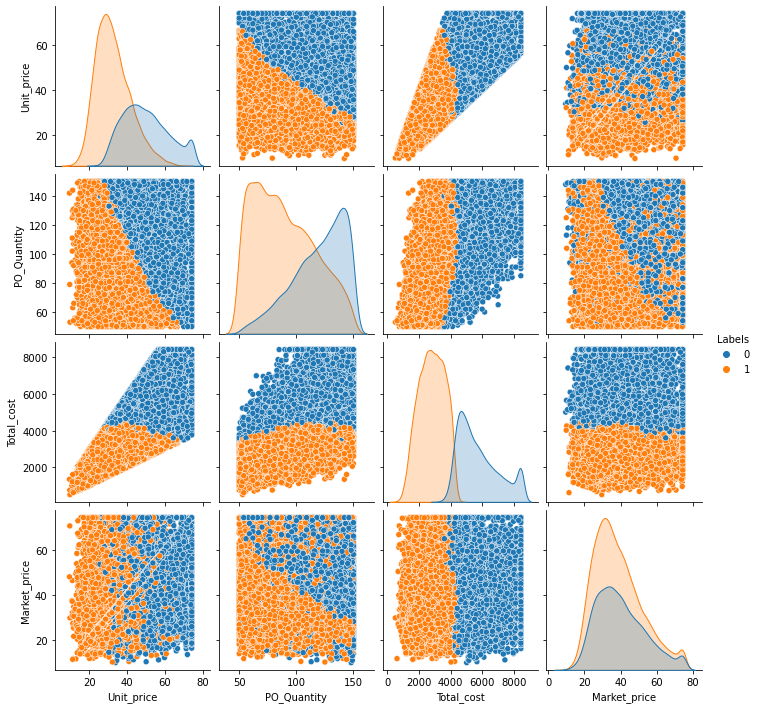

In [55]:
# Pairplot with respect to cluster Labels

list2 = dataset.loc[:, ['Unit_price', 'PO_Quantity', 'Total_cost', 'Market_price', 'Labels']]
sns.pairplot(list2, 'Labels')

## Train-Test Split

In [56]:
# Splitting the data into x and y

X = sc_dataset.loc[:, sc_dataset.columns != 'Labels']
Y = sc_dataset.Labels

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 45, stratify = Y)

print(f'x_train length: {x_train.shape}')
print(f'y_train length: {y_train.shape}')
print(f'x_test length: {x_test.shape}')
print(f'y_test length: {y_test.shape}')

x_train length: (15904, 92)
y_train length: (15904,)
x_test length: (5302, 92)
y_test length: (5302,)


# MODEL BUILDING

## Naive Bayes Classifier


Naive Bayes Train Accuracy: 0.9373113682092555

Naive Bayes Test Accuracy: 0.9417201056205206

Classification Report : 
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      2256
           1       0.91      0.99      0.95      3046

    accuracy                           0.94      5302
   macro avg       0.95      0.93      0.94      5302
weighted avg       0.95      0.94      0.94      5302


Confusion Matrix : 
  [[1967  289]
 [  20 3026]]
AUC Score: 0.9326655874696731


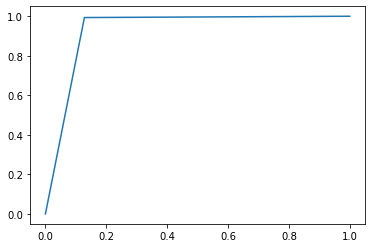

In [57]:
# Bernoulli Naive Bayes 

bnb = BernoulliNB(alpha = 0.2) # Initializing the classfier

bnb.fit(x_train, y_train) # fittig to train data

bnb_pred = bnb.predict(x_test)
bnb_accuracy = accuracy_score(bnb_pred, y_test)

print(f'\nNaive Bayes Train Accuracy: {accuracy_score(bnb.predict(x_train), y_train)}')
print(f'\nNaive Bayes Test Accuracy: {bnb_accuracy}')
print(f'\nClassification Report : \n{classification_report(bnb_pred, y_test)}')
print(f'\nConfusion Matrix : \n  {confusion_matrix(bnb_pred, y_test)}')

# The ROC Curve 
fpr, tpr, thresholds = roc_curve(bnb_pred, y_test)

# Plot the ROC curve
plt.plot(fpr, tpr)

# AUC score
bnb_auc_score = roc_auc_score(bnb_pred, y_test)
print(f'AUC Score: {bnb_auc_score}')

## Support Vector Classifier


SVC Train Accuracy: 0.9986795774647887

SVC Test Accuracy: 0.976612599019238

Classification Report : 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1947
           1       0.99      0.98      0.98      3355

    accuracy                           0.98      5302
   macro avg       0.97      0.98      0.97      5302
weighted avg       0.98      0.98      0.98      5302


Confusion Matrix : 
  [[1905   42]
 [  82 3273]]
AUC Score: 0.9769936093359267


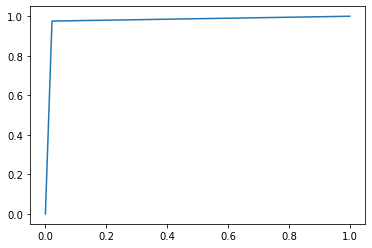

In [58]:
# SVC Classfier 

svc = SVC() # Initializing the classfier

svc.fit(x_train, y_train) # fittig to train data

svc_pred = svc.predict(x_test)
svc_accuracy = accuracy_score(svc_pred, y_test)

print(f'\nSVC Train Accuracy: {accuracy_score(svc.predict(x_train), y_train)}')
print(f'\nSVC Test Accuracy: {svc_accuracy}')
print(f'\nClassification Report : \n{classification_report(svc_pred, y_test)}')
print(f'\nConfusion Matrix : \n  {confusion_matrix(svc_pred, y_test)}')

# The ROC Curve 
fpr, tpr, thresholds = roc_curve(svc_pred, y_test)

# Plot the ROC curve
plt.plot(fpr, tpr)

# AUC score
svc_auc_score = roc_auc_score(svc_pred, y_test)
print(f'AUC Score: {svc_auc_score}')

## Logistic Classifier


SVC Train Accuracy: 0.9986795774647887

SVC Test Accuracy: 0.9971708789136176

Classification Report : 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1982
           1       1.00      1.00      1.00      3320

    accuracy                           1.00      5302
   macro avg       1.00      1.00      1.00      5302
weighted avg       1.00      1.00      1.00      5302


Confusion Matrix : 
  [[1977    5]
 [  10 3310]]
AUC Score: 0.9972326237340887


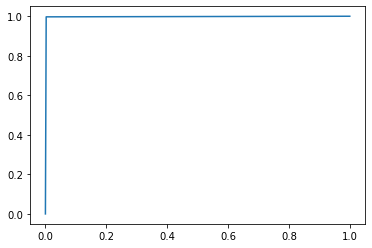

In [59]:
# Logistic Regression Classfier 

lr = LogisticRegression(n_jobs = -1) # Initializing the classfier

lr.fit(x_train, y_train) # fittig to train data

lr_pred = lr.predict(x_test)
lr_accuracy = accuracy_score(lr_pred, y_test)

print(f'\nSVC Train Accuracy: {accuracy_score(lr.predict(x_train), y_train)}')
print(f'\nSVC Test Accuracy: {lr_accuracy}')
print(f'\nClassification Report : \n{classification_report(lr_pred, y_test)}')
print(f'\nConfusion Matrix : \n  {confusion_matrix(lr_pred, y_test)}')

# The ROC Curve 
fpr, tpr, thresholds = roc_curve(lr_pred, y_test)

# Plot the ROC curve
plt.plot(fpr, tpr)

# AUC score
lr_auc_score = roc_auc_score(lr_pred, y_test)
print(f'AUC Score: {lr_auc_score}')

## Random Forest Classifier

Best Estimator: RandomForestClassifier(max_depth=7, min_samples_leaf=2, n_estimators=20)

Random Forest Train Accuracy: 0.977112676056338

Random Forest Test Accuracy: 0.9758581667295361

Classification Report : 
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1927
           1       0.99      0.97      0.98      3375

    accuracy                           0.98      5302
   macro avg       0.97      0.98      0.97      5302
weighted avg       0.98      0.98      0.98      5302


Confusion Matrix : 
  [[1893   34]
 [  94 3281]]
AUC Score: 0.9772520709604259


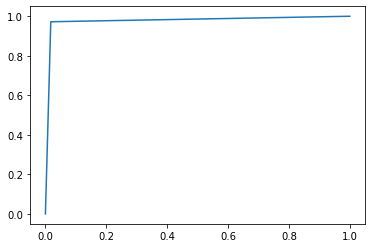

In [60]:
rfc = RandomForestClassifier() # Initializing RandomForestClassifier 

params = {'n_estimators': [10, 20, 50, 100],
          'max_depth' : [2, 4, 5, 7],
          'min_samples_leaf': [2, 3, 4],
         'max_features': ['auto', 'sqrt', 'log2']}

grid_rf = GridSearchCV(estimator = rfc,
                   param_grid = params,
                   n_jobs = -1,
                   cv = 5)

grid_rf.fit(x_train, y_train) # Fitting the data to decision tree model

print(f'Best Estimator: {grid_rf.best_estimator_}')
grid_rf_pred = grid_rf.predict(x_test) # Predicting the results

grid_rf_accuracy = accuracy_score(grid_rf_pred, y_test)

print(f'\nRandom Forest Train Accuracy: {accuracy_score(grid_rf.predict(x_train), y_train)}')
print(f'\nRandom Forest Test Accuracy: {grid_rf_accuracy}')
print(f'\nClassification Report : \n{classification_report(grid_rf_pred, y_test)}')
print(f'\nConfusion Matrix : \n  {confusion_matrix(grid_rf_pred, y_test)}')

# The ROC Curve 
fpr, tpr, thresholds = roc_curve(grid_rf_pred, y_test)

# Plot the ROC curve
plt.plot(fpr, tpr)

# AUC score
grid_rf_auc_score = roc_auc_score(grid_rf_pred, y_test)
print(f'AUC Score: {grid_rf_auc_score}')

    Logistic Regression is the best model to predict fraud.
    It gives an accuracy of 99% with F1 score of 0.99 and AUC score of 0.9943

In [61]:
# Selecting Logistic regression as Best Model

best_model = lr

best_model.get_params() # Checking the paramters for the best model

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [62]:
pickle.dump(best_model, open('Best_Model.pickle', 'wb'))